<a href="https://colab.research.google.com/github/YoshifumiMiyagi/IP_LDL/blob/main/IP_LDL2_ipynb(DF2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import early_stopping

raw = pd.read_excel('/content/drive/MyDrive/R7_2_10_DB2_miyagi.xlsx')
print(raw.shape)
raw.head()

(71, 35)


,カルテ番号,Birth_date,Examin_date,"Age_lessthan10_0,morethan11_1",Age_y,Age_m,Age_day,sex,Hight,Weight,...,BPStart_mmHg_2,BPEnd_mmHg_2,BPInterval_mmHg_2,BPStart_mmHg_3,BPEnd_mmHg_3,BPInterval_mmHg_3,Time_2,Time_3,Time_12,Time_13
0,10637737,36069,43319,1,19,10,5.0,female,150.0,NaN,...,101.000000,103.666667,2.666667,78.000000,79.000000,1.000000,0.038339,0.067093,0.036036,0.063063
1,12046291,37930,43692,1,15,9,9.0,female,158.2,47.0,...,98.188679,107.018868,8.830189,70.716981,77.584906,6.867925,0.063380,0.084507,0.037037,0.049383
2,12812817,38630,45133,1,17,9,19.0,female,163.0,45.8,...,96.873239,102.704225,5.830986,65.126761,77.436620,12.309859,0.044280,0.044280,0.048193,0.048193
3,10843052,36984,42586,1,15,4,1.0,male,174.1,56.5,...,110.228571,116.028571,5.800000,71.285714,72.942857,1.657143,0.067606,0.059155,0.054422,0.047619
4,10982985,40485,44412,0,10,9,0.0,female,141.0,35.0,...,110.272727,117.363636,7.090909,71.272727,78.363636,7.090909,0.047022,0.075235,0.054945,0.087912


In [4]:
data = raw.iloc[:,3:]
data['sex'] = data['sex'].map({'male':1,'female':0})
data['Age_day'] = data['Age_day'].fillna(0)
data['LDL'] = data['LDL']
data = data.dropna(subset=['LDL'])
data['Weight'] = data['Weight'].fillna(data['Weight'].mean())

In [6]:
data2=data.copy()

RMV = ["sex"]
NUM_FEATURES = [c for c in data.columns if not c in RMV]

data2[NUM_FEATURES] = data2[NUM_FEATURES]
data3 = pd.concat([data2[NUM_FEATURES],data2["sex"]],axis=1)
data3.isnull().sum()

,0
"Age_lessthan10_0,morethan11_1",0
Age_y,0
Age_m,0
Age_day,0
Hight,0
Weight,0
HR,0
sysBP,0
dysBP,0
aveBP,0


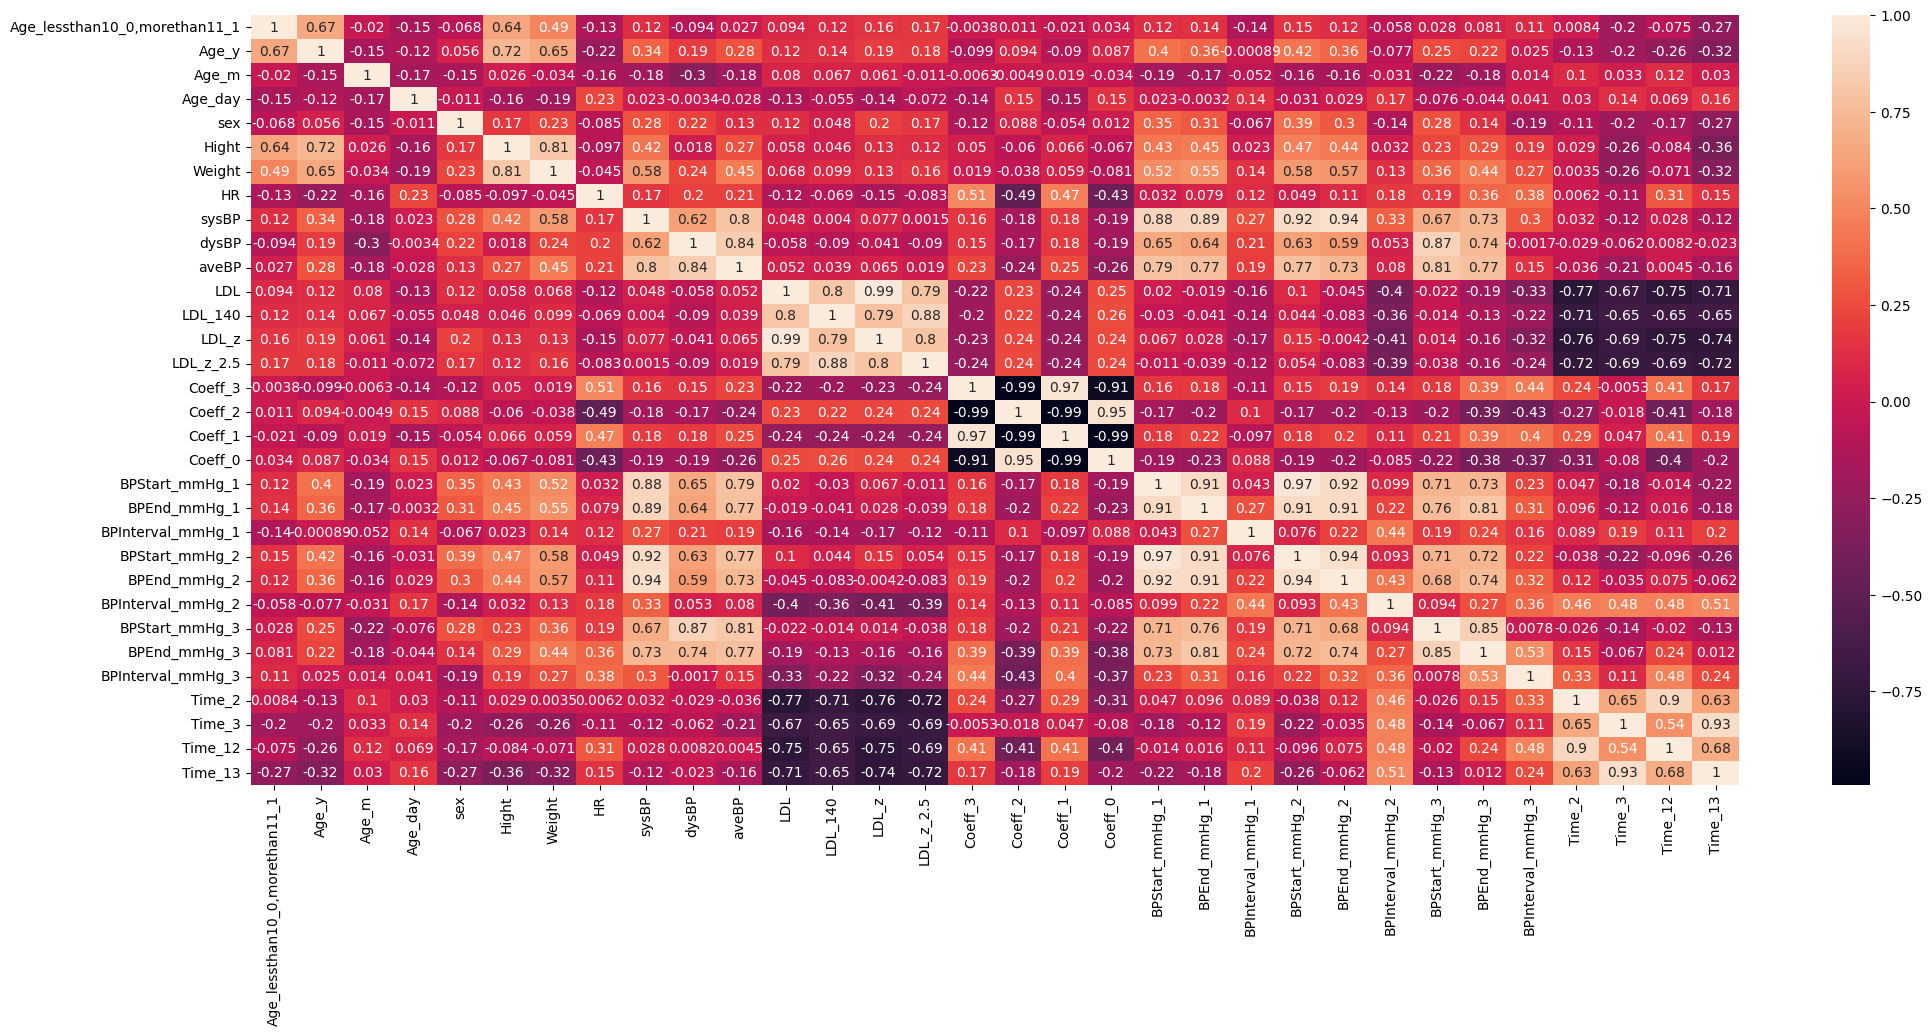

In [5]:
# prompt: dataのcorr　heatmap annot=T

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24, 10))
sns.heatmap(data.corr(), annot=True)
plt.show()


In [7]:
data3.corr()["LDL"].abs().sort_values(ascending=False)

,LDL
LDL,1.000000
LDL_z,0.991505
LDL_140,0.799540
LDL_z_2.5,0.791380
Time_2,0.768797
Time_12,0.747212
Time_13,0.705633
Time_3,0.671431
BPInterval_mmHg_2,0.399783
BPInterval_mmHg_3,0.331592


In [ ]:
#feature =["TimeStart_s_1","Coeff_3",'aveBP',"LDL",'Coeff_2','sex','CAVI(R)','ABI(R)',"BPInterval_mmHg_2"]

In [8]:
#data3[feature].describe()
data3.describe()

,"Age_lessthan10_0,morethan11_1",Age_y,Age_m,Age_day,Hight,Weight,HR,sysBP,dysBP,aveBP,...,BPEnd_mmHg_2,BPInterval_mmHg_2,BPStart_mmHg_3,BPEnd_mmHg_3,BPInterval_mmHg_3,Time_2,Time_3,Time_12,Time_13,sex
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,...,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,0.605634,11.591549,5.704225,14.746479,145.518310,40.601429,69.577465,115.521127,67.535211,85.309859,...,112.126961,9.167004,74.904111,84.187169,9.283058,0.111815,0.112971,0.125394,0.125944,0.422535
std,0.492193,2.686354,3.361098,8.962969,12.575274,12.504222,15.025371,11.441602,8.049545,7.168565,...,11.768509,4.015280,9.637395,11.334842,5.891614,0.045464,0.054171,0.055628,0.058963,0.497479
min,0.000000,7.000000,0.000000,0.000000,119.100000,18.900000,38.000000,98.000000,54.000000,69.000000,...,87.094340,1.902439,54.676923,64.361702,0.000000,0.038339,0.030000,0.036036,0.034884,0.000000
25%,0.000000,10.000000,3.000000,8.000000,136.900000,30.900000,61.000000,108.000000,62.000000,81.000000,...,106.000000,6.374801,67.644368,75.338835,5.629540,0.067637,0.071581,0.079002,0.075047,0.000000
50%,1.000000,11.000000,6.000000,15.000000,144.400000,40.400000,69.000000,114.000000,67.000000,84.000000,...,109.939394,8.333333,72.313433,81.089552,8.968750,0.115830,0.111111,0.117021,0.120690,0.000000
75%,1.000000,12.000000,9.000000,22.000000,153.250000,46.900000,76.500000,121.000000,72.000000,89.000000,...,115.718020,11.647287,81.510870,90.082184,12.208939,0.152185,0.141701,0.164855,0.168699,1.000000
max,1.000000,22.000000,11.000000,30.000000,176.000000,80.600000,139.000000,148.000000,93.000000,107.000000,...,151.470588,21.954545,99.918367,115.068182,39.187500,0.192308,0.340206,0.294118,0.320388,1.000000


# Features creation

In [9]:
#Train = data3[feature].copy()
Train = data3.copy()
Train.isnull().sum()

,0
"Age_lessthan10_0,morethan11_1",0
Age_y,0
Age_m,0
Age_day,0
Hight,0
Weight,0
HR,0
sysBP,0
dysBP,0
aveBP,0


In [10]:
Train.columns

Index(['Age_lessthan10_0,morethan11_1', 'Age_y', 'Age_m', 'Age_day', 'Hight',
       'Weight', 'HR', 'sysBP', 'dysBP', 'aveBP', 'LDL', 'LDL_140', 'LDL_z',
       'LDL_z_2.5', 'Coeff_3', 'Coeff_2', 'Coeff_1', 'Coeff_0',
       'BPStart_mmHg_1', 'BPEnd_mmHg_1', 'BPInterval_mmHg_1', 'BPStart_mmHg_2',
       'BPEnd_mmHg_2', 'BPInterval_mmHg_2', 'BPStart_mmHg_3', 'BPEnd_mmHg_3',
       'BPInterval_mmHg_3', 'Time_2', 'Time_3', 'Time_12', 'Time_13', 'sex'],
      dtype='object')

In [11]:
def numeric_fe_df2(df):
    df['Time_2_*_Coeff_3'] = df['Time_2'] *np.log1p(df['Coeff_3'])
    df['Time_2_*_aveBP'] = df['Time_2'] * df['aveBP']
    df['Coeff_3_/_Time_2'] = np.log1p(df['Coeff_3']) / df['Time_2']
    df['Coeff_3_/_aveBP'] = np.log1p(df['Coeff_3']) / df['aveBP']

    df['Coeff_2_/_Time_2'] = np.log1p(df['Coeff_2']) / df['Time_2']
    df['Coeff_2_/_aveBP'] = np.log1p(df['Coeff_2']) / df['aveBP']
    df['Coeff_2_*_aveBP'] = np.log1p(df['Coeff_2']) * df['aveBP']
    df['Coeff_2_*_Time_2'] = np.log1p(df['Coeff_2']) * df['Time_2']
    df['Coeff_2_*_aveBP'] = np.log1p(df['Coeff_2']) * df['aveBP']

    #df['TimeStart_s_1_*_CAVI(R)'] = df['TimeStart_s_1'] * df['CAVI(R)']
    #df['TimeStart_s_1_*_ABI(R)'] = df['TimeStart_s_1'] * df['ABI(R)']

    df['Time_2_/_aveBP'] = df['Time_2'] / df['aveBP']
    df['Coeff_3_*_aveBP'] = np.log1p(df['Coeff_3']) * df['aveBP']
    df['Coeff_2_*_aveBP'] = np.log1p(df['Coeff_2']) * df['aveBP']

    df['sex_*_Time_2'] = df['sex'] * df['Time_2']
    df['sex_*_Coeff_3'] = df['sex'] * np.log1p(df['Coeff_3'])
    df['sex_*_aveBP'] = df['sex'] * df['aveBP']
    #df['sex_*_CAVI(R)'] = df['sex'] * df['CAVI(R)']
    #df['sex_*_ABI(R)'] = df['sex'] * df['ABI(R)']
    df['sex_*_Coeff_2'] = df['sex'] * np.log1p(df['Coeff_2'])
    df['sex_*_Time_2_/_aveBP'] = df['sex'] * df['Time_2'] / df['aveBP']
    df['sex_*_Coeff_3_*_aveBP'] = df['sex'] * np.log1p(df['Coeff_3']) * df['aveBP']
    df['sex_*_Coeff_2_*_aveBP'] = df['sex'] * np.log1p(df['Coeff_2']) * df['aveBP']
    #df['sex_*_Time_2_*_CAVI(R)'] = df['sex'] * df['TimeStart_s_1'] * df['CAVI(R)']
    #df['sex_*_Time_2_*_ABI(R)'] = df['sex'] * df['TimeStart_s_1'] * df['ABI(R)']
    df['sex_*_Time_2_/_aveBP'] = df['sex'] * df['Time_2'] / df['aveBP']

    df['BPInterval_mmHg_2 + Time_2'] = df['BPInterval_mmHg_2'] + df['Time_2']

    return df

In [12]:
TRAIN = numeric_fe_df2(Train)

In [13]:
#X, y = Dat.drop('LDL',axis=1), dat['LDL']/dat['BPInterval_mmHg_2 + TimeStart_s_1']
#X, y = Train.drop(['LDL','LDL_140','LDL_z','LDL_z_2.5'],axis=1), Train['LDL']/Train['BPInterval_mmHg_2 + Time_2']
X, y = TRAIN.drop(['LDL','LDL_140','LDL_z','LDL_z_2.5'],axis=1), TRAIN['LDL']/TRAIN['BPInterval_mmHg_2 + Time_2']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# # 正規化 (Min-Max スケーリング)
scaler_minmax = MinMaxScaler()
X_train_ = scaler_minmax.fit_transform(X_train)
X_test_ = scaler_minmax.transform(X_test)

# # 標準化 (Z-score 標準化)
# scaler_standard = StandardScaler()
# X_train = scaler_standard.fit_transform(X_train)
# X_test = scaler_standard.transform(X_test)


In [17]:
# prompt: 線形回帰

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Print coefficients and intercept
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

Mean Squared Error: 344.1153964789234
R-squared: -0.2326984088766555
Coefficients: [ 1.78700962e+01 -1.22673940e-03  7.55647779e-01 -1.84707889e-01
 -7.62524554e-01  1.17253554e-01 -1.73142793e-02 -5.56143922e-01
  1.41546029e+00 -1.72579876e+00 -1.58222667e+07 -1.64229108e+05
 -3.11211369e+02 -6.65181361e-01 -7.86112353e-02  2.53492259e-01
  8.26498183e-01 -4.64992054e+05  4.64992923e+05 -3.05609642e+05
 -1.19130430e+05  1.19128814e+05 -1.19129524e+05  1.54780320e+05
  4.50111832e+02  6.59060203e+02 -4.84831095e+02 -6.80647050e+00
 -1.13934449e+08  3.14230481e+01 -2.21096121e+06 -9.11911159e+09
 -2.17366066e+03 -5.63858608e+06  1.51663583e+03 -1.17908075e+05
  9.36802240e+04  1.18874629e+06 -7.87968220e+02  2.14669199e+08
  7.83321159e-02  2.04774878e+05  6.08249137e+04 -2.60501366e+06
 -2.48876571e+03 -1.59384922e+05]
Intercept: 382.42207252628947


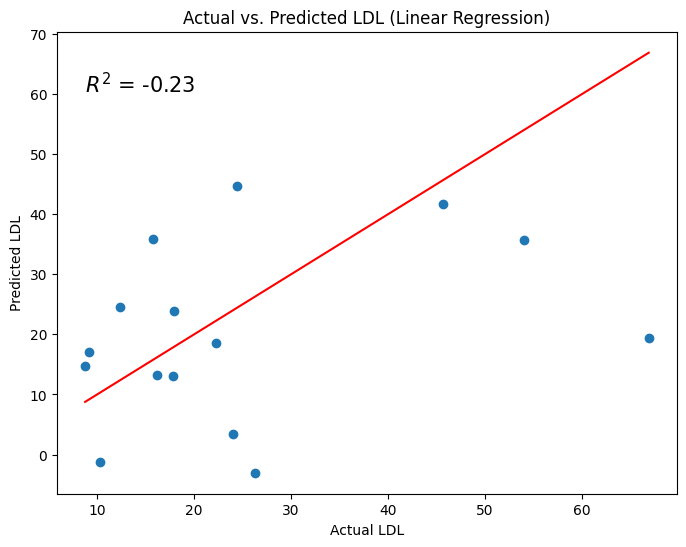

In [18]:
# prompt: 予測の線形回帰のプロット

# Plot the predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Add a diagonal line for reference
plt.xlabel("Actual LDL")
plt.ylabel("Predicted LDL")
plt.text(min(y_test), max(y_test) * 0.9,f'$R^2$ = {r2:.2f}', fontsize=15)
plt.title("Actual vs. Predicted LDL (Linear Regression)")
plt.show()

In [19]:
# prompt: 決定木で

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 決定木モデルの作成と学習
model = DecisionTreeRegressor(random_state=42, max_depth=2)  # random_state を設定
model.fit(X_train, y_train)

# テストデータでの予測
y_pred = model.predict(X_test)

# モデルの評価
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 88.69419011470633
R^2 Score: 0.6822775494798339


In [20]:

import xgboost as xgb

# Create XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=9,max_depth=3,reg_lambda=0.1,eta=0.31) # Use appropriate objective function

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Mean Squared Error: {mse}")
print(f"XGBoost R-squared: {r2}")

XGBoost Mean Squared Error: 39.57706187062406
XGBoost R-squared: 0.8582261017811816


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}")

MSE: 39.57706187062406, RMSE: 6.291030270998865, MAE: 4.3339853540635, R^2: 0.8582261017811816


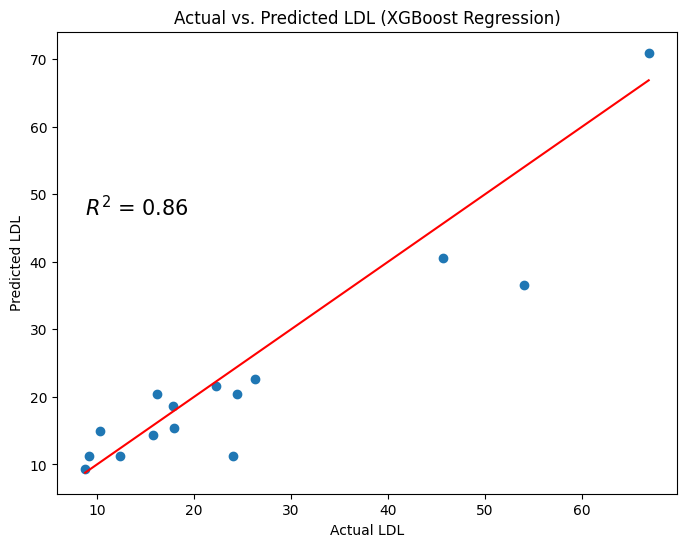

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Add a diagonal line for reference
plt.xlabel("Actual LDL")
plt.ylabel("Predicted LDL")
plt.text(min(y_test), max(y_test) * 0.7,f'$R^2$ = {r2:.2f}', fontsize=15)
plt.title("Actual vs. Predicted LDL (XGBoost Regression)")
plt.show()

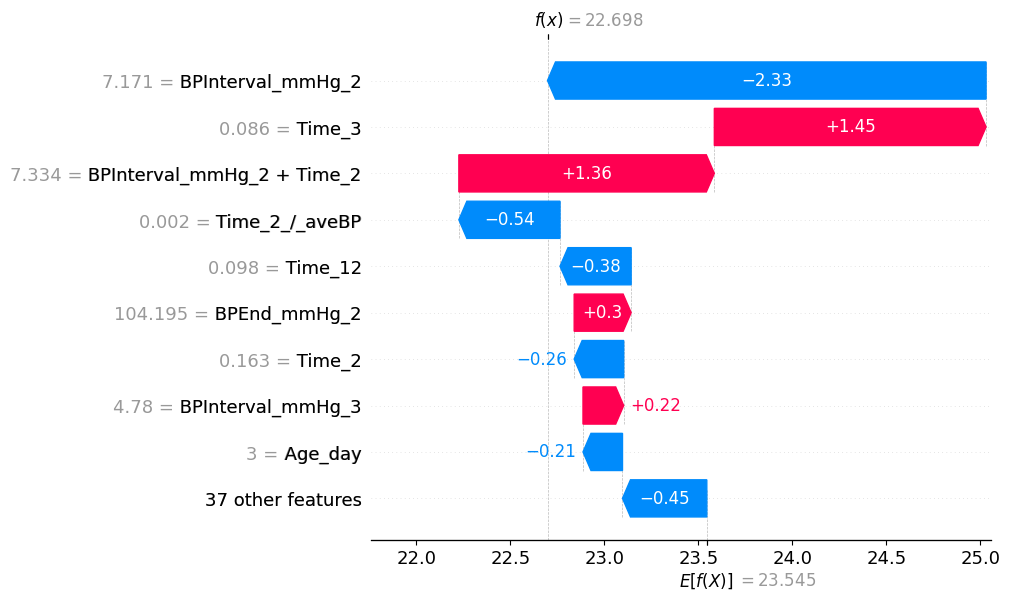

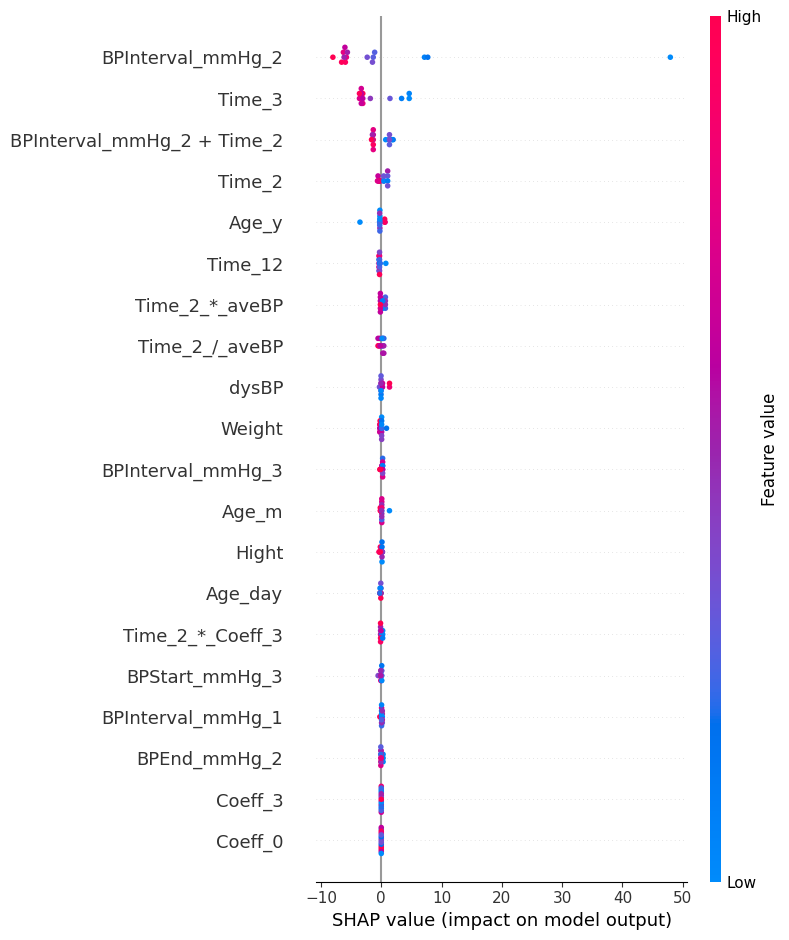

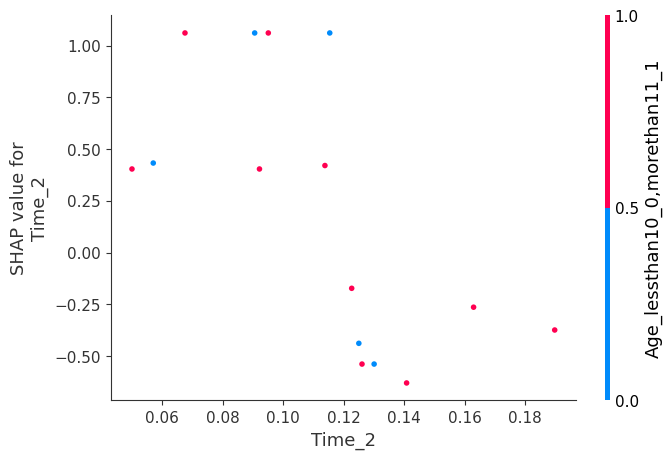

In [24]:
# prompt: SHAP
import shap

# Assuming 'model' is your trained XGBoost model and 'X_test' is your test data
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

# Dependence plot
shap.dependence_plot("Time_2", shap_values.values, X_test)
